# Steps

## 1. [Import the Libraries](#1.-Import-the-libraries)
## 2. [Load the data](#2.-Load-the-Data)
## 3. [Preprocessing](#3.-Preprocessing-the-Data)
- 3.1 [OneHotEncoding](#3.1-OneHotEncoding-with-LabelEncoder)
- 3.2 [Standard Scaling](#3.2-Standard-Scaling)
## 4. [Data preparation](#4.-Data-Preparation)
## 5. [Model training](#5.-Model-Training)
## 6. [Model Evaluation](#6.-Mean-Average-Precision)
- 6.1 [MAP@3 Score](#6.1-Model-Score)
## 7. [Feature Engineering](#7.-Adding-New-Features)
- 7.1 [Numeric Features](#7.1-Numerical-Columns)
## [Submission](#Submit-the-test-data-prediction)

## 1. Import the libraries

[🔝 Return to top](#Steps)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

## 2. Load the Data

[🔝 Return to top](#Steps)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.set_index('id', inplace = True)
test_data.set_index('id', inplace = True)

## 3. Preprocessing the Data

[🔝 Return to top](#Steps)

In [3]:
numerical_columns = [ col for col in train_data.columns if train_data[col].dtype != 'O']
#['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
#['Soil Type', 'Crop Type', 'Fertilizer Name']

In [4]:
numerical_columns

['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

In [5]:
train_data.iloc[:1]

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28


### 3.1 OneHotEncoding with LabelEncoder

[🔝 Return to top](#Steps)

In [6]:
labeler = LabelEncoder()
test_data['Fertilizer Name'] = 'z' # added column so that LabelEncoder can recognize while inverse_transform
for col_name in categorical_columns:
    test_data[col_name] = labeler.fit_transform(test_data[col_name])
    train_data[col_name] = labeler.fit_transform(train_data[col_name])

### 3.2 Standard Scaling

[🔝 Return to top](#Steps)

## 4. Data Preparation

[🔝 Return to top](#Steps)

In [7]:
X = train_data.drop(['Fertilizer Name'], axis = 1)
y = train_data['Fertilizer Name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 5. Model Training 

[🔝 Return to top](#Steps)

In [8]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)

## 6. Mean Average Precision

[🔝 Return to top](#Steps)

In [9]:
# MAP@3
def mapk(y_test, y_pred_proba,k =3):
    top3_indices = np.argsort(y_pred_proba, axis = 1)[:, ::-1][ : ,:3]
    sum_ap = 0

    for indx, lst in enumerate(top3_indices):
        true_label = y_test.iloc[indx]
        '''
        if true_label in lst:
            ap = 1 / (list(lst).index(true_label) + 1)  
        else:
            ap = 0
        '''
                    # OR
        
        try:
            ap = 1 / (list(lst).index(true_label) + 1)
        except ValueError:
            ap = 0

        sum_ap += ap

    return (sum_ap / len(y_test))

### 6.1 Model Score

In [10]:
mapk(y_test, y_pred_proba) # Before feature Engineering

0.32288555555562565

## 7. Adding New Features

[🔝 Return to top](#Steps)

### 7.1 Numerical Columns

In [11]:
# Adding Moisture + Humidity columns
train_data['Moisture_Humidity'] = train_data['Moisture'] + train_data['Humidity']
test_data['Moisture_Humidity'] = test_data['Moisture'] + test_data['Humidity']

# Adding Potassium - Phosphorous columns
train_data['Potassium_Phosphorous'] = train_data['Potassium'] * train_data['Phosphorous']
test_data['Potassium_Phosphorous'] = test_data['Potassium'] * test_data['Phosphorous']

# Adding Crop Type - Soil Type
train_data['Crop_Soil'] = train_data['Crop Type'] - train_data['Soil Type']
test_data['Crop_Soil'] = test_data['Crop Type'] - test_data['Soil Type']

In [14]:
train_data.corr()['Fertilizer Name'].sort_values(ascending = False)

Fertilizer Name          1.000000
Soil Type                0.016576
Moisture_Humidity        0.015207
Moisture                 0.011493
Humidity                 0.010626
Temparature              0.001727
Nitrogen                -0.004725
Phosphorous             -0.006127
Potassium               -0.010872
Potassium_Phosphorous   -0.011589
Crop Type               -0.013041
Crop_Soil               -0.018704
Name: Fertilizer Name, dtype: float64

In [15]:
X = train_data.drop(['Fertilizer Name'], axis = 1)
y = train_data['Fertilizer Name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

f_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

f_model.fit(X_train, y_train)
y_pred_proba = f_model.predict_proba(X_test)

In [16]:
mapk(y_test, y_pred_proba) # After feature Engineering

0.320773333333403

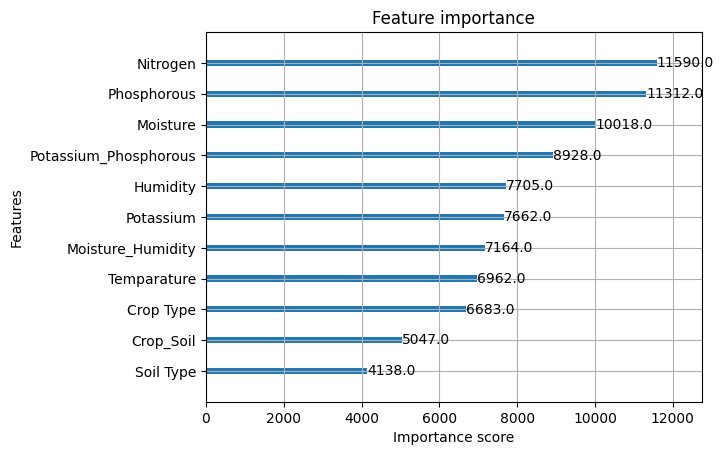

In [19]:
from xgboost import plot_importance

plot_importance(model, max_num_features=15)
plt.show()

In [20]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

Soil Type                0.007155
Crop Type                0.004768
Phosphorous              0.004719
Moisture                 0.003478
Crop_Soil                0.003111
Potassium_Phosphorous    0.002191
Temparature              0.002025
Potassium                0.001992
Moisture_Humidity        0.001843
Nitrogen                 0.001752
Humidity                 0.001361
dtype: float64


## Submit the test data prediction

[🔝 Return to top](#Steps)

In [17]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X,y)

probs = model.predict_proba(test_data.drop(['Fertilizer Name'], axis =1))
top3_indices = np.argsort(probs , axis = 1)[ : , ::-1][:,:3]
top3_labels = labeler.inverse_transform(top3_indices.ravel()).reshape(top3_indices.shape)

pred_top3 = [' '.join(row) for row in top3_labels]

In [18]:
submission = pd.DataFrame({
    "id" : test_data.index,
    "Fertilizer Name" : pred_top3
})

submission.to_csv("submission.csv", index = False) 
submission.head()

,id,Fertilizer Name
0,750000,DAP 28-28 14-35-14
1,750001,17-17-17 20-20 10-26-26
2,750002,14-35-14 10-26-26 20-20
3,750003,14-35-14 17-17-17 Urea
4,750004,20-20 10-26-26 17-17-17
